In [1]:
import torch 
from torch.nn import functional as F
import matplotlib.pyplot as plt 

from sys import exit as e

plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
words = open("./data/names.txt", 'r').read().splitlines()
print(len(words))

32033


In [3]:
unique_char = sorted(list(set(''.join(words))))

stoi = {c:i+1 for i, c in enumerate(unique_char)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
def build_dataset(words, block_size, stoi):
  xs = []
  ys = []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      xs.append(context)
      ys.append(stoi[ch])
      # print("x: ", ''.join([itos[c] for c in context]))
      # print("label: ", ch)
      context = context[1:] + [stoi[ch]]
  
  xs = torch.tensor(xs)
  ys = torch.tensor(ys)
  return xs, ys

In [5]:
import random 
random.seed(42)
random.shuffle(words)

t1 = int(0.8 * len(words))
t2 = int(0.9 * len(words))



block_size = 3
Xtr, ytr = build_dataset(words[:t1], block_size=block_size, stoi=stoi)
Xval, yval = build_dataset(words[t1:t2], block_size=block_size, stoi=stoi)
Xte, yte = build_dataset(words[t2:], block_size=block_size, stoi=stoi)

print(Xtr.shape, Xval.shape, Xte.shape)
print(ytr.shape, yval.shape, yte.shape)

torch.Size([182625, 3]) torch.Size([22655, 3]) torch.Size([22866, 3])
torch.Size([182625]) torch.Size([22655]) torch.Size([22866])


In [18]:
n_embed = 10 
n_hidden = 200
vocab_size = len(unique_char)+1

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 0.02 # Kaiming Init to maintain std of weights in forward propagation
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

W1bn_gain = torch.ones((1, n_hidden))
W1bn_bias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, W1bn_gain, W1bn_bias]

# REDUNDANT BUT FOLLOW THIS
for p in parameters:
  p.requires_grad = True 

running_bmean = torch.zeros((1, n_hidden))
running_bstd = torch.ones(1, n_hidden)

print(sum(p.nelement() for p in parameters))

12297


In [19]:
epochs = 200000
batch_size = 32 
total_loss = []
steps = []

for epoch in range(epochs+1):
  b_idx = torch.randint(0, Xtr.shape[0], size=(batch_size, ), generator=g)
  Xb = Xtr[b_idx]
  yb = ytr[b_idx]

  emb = C[Xb]
  embcat = emb.view(batch_size, -1)
  hpreact = embcat @ W1 + b1

  # Batch Normalization
  bmean_epoch = hpreact.mean(0, keepdim=True)
  bstd_epoch = hpreact.std(0, keepdim=True)
  hpreact = W1bn_gain * (hpreact - bmean_epoch)/bstd_epoch + W1bn_bias

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 

  with torch.no_grad():
    running_bmean = 0.999* running_bmean + 0.001 * bmean_epoch 
    running_bstd = 0.999* running_bstd + 0.001 * bstd_epoch 

  loss = F.cross_entropy(logits, yb)

  lr = 0.1 if epoch < 100000 else 0.01
  for p in parameters:
    p.grad = None 
  loss.backward()
  for p in parameters:
    p.data += -lr * p.grad
  
  if epoch % 10000 ==0:
    print(f"{epoch}/{epochs}: {loss.item()}")
  total_loss.append(loss.log10().item())





0/200000: 3.3146889209747314
10000/200000: 2.1549839973449707
20000/200000: 2.305853843688965
30000/200000: 2.4165210723876953
40000/200000: 1.950498342514038
50000/200000: 2.2924675941467285
60000/200000: 2.391138792037964
70000/200000: 2.0872690677642822
80000/200000: 2.3733530044555664
90000/200000: 2.15968918800354
100000/200000: 1.9075390100479126
110000/200000: 2.2213664054870605
120000/200000: 1.8906158208847046
130000/200000: 2.4626622200012207
140000/200000: 2.377314567565918
150000/200000: 2.228055238723755
160000/200000: 1.8634312152862549
170000/200000: 1.800894021987915
180000/200000: 2.063849449157715
190000/200000: 1.926555871963501
200000/200000: 2.269064426422119


In [15]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bmean = hpreact.mean(0, keepdim=True)
  bstd = hpreact.std(0, keepdim=True)

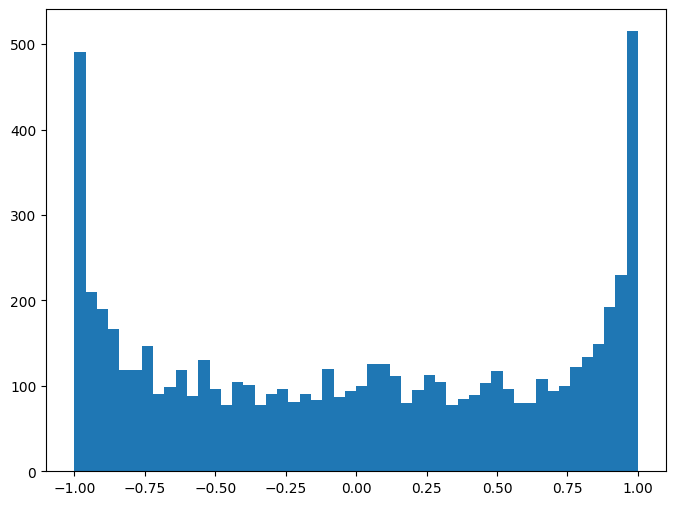

In [8]:
plt.hist(h.flatten().detach(), 50);

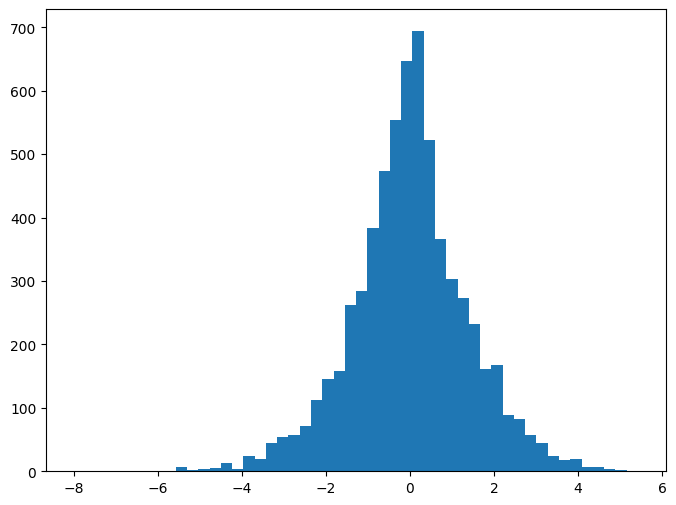

In [9]:
plt.hist(hpreact.flatten().detach(), 50);

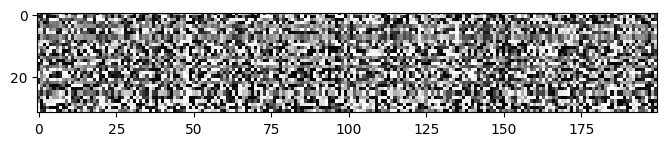

In [10]:
plt.imshow(h.detach(), cmap='gray')
plt.show()

In [20]:
@torch.no_grad()
def split_loss(split):
  data_dict = {
    'train': (Xtr, ytr), 
    'val': (Xval, yval), 
    'test': (Xte, yte)
  }
  X, y = data_dict[split]

  embcat = C[X].view(X.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = W1bn_gain * ((hpreact - running_bmean)/running_bstd) + W1bn_bias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, y)
  print(loss.item())

split_loss('train')
split_loss('val')
  

2.0583784580230713
2.106937885284424


In [21]:
g1 = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    embcat = C[torch.tensor(context)].view(1, -1)
    hpreact = embcat @ W1 + b1 
    hpreact = W1bn_gain * ((hpreact - running_bmean)/running_bstd) + W1bn_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 

    probs = F.softmax(logits, dim=-1)

    ix = torch.multinomial(probs, 1, generator=g).item()
    out.append(ix)

    if ix == 0:
      break
    context = context[1:] + [ix]

  print(''.join(itos[o] for o in out))



kadenavarlindicon.
hosapthan.
emna.
greela.
oco.
keen.
awellian.
emotyn.
abeus.
jose.
shan.
liah.
bry.
raniyan.
nylaylin.
kotana.
aleah.
jazeegan.
pisreena.
ariyaan.
